In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 2.6 MB/s eta 0:00:57
   ---------------------------------------- 1.6/150.0 MB 3.8 MB/s eta 0:00:39
    --------------------------------------- 2.6/150.0 MB 4.1 MB/s eta 0:00:36
    --------------------------------------- 3.7/150.0 MB 4.5 MB/s eta 0:00:33
   - -------------------------------------- 5.0/150.0 MB 4.8 MB/s eta 0:00:31
   - -------------------------------------- 6.3/150.0 MB 5.0 MB/s eta 0:00:29
   -- ------------------------------------- 8.1/150.0 MB 5.5 MB/s eta 0:00:26
   -- ------------------------------------- 10.0/150.0 MB 5.8 MB/s eta 0:00:24
   --- ------------------------------------ 11.8/150.0 MB 6.1 MB/s eta 0:00:23
   --- ------------------------------------ 13.4/150.0 MB 6.3 MB/s eta 0:00:22
   ---- ----------------------------------- 15.5/150.0 MB 6.7 MB/s eta 0:00

In [3]:
# Data analysis & manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Saving the model
import joblib

In [4]:
import pandas as pd

df = pd.read_csv("F:\Bengaluru_House_Data.csv")
df.head()
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [5]:
# Drop columns with too many missing or irrelevant values
df = df.drop(['area_type', 'society', 'availability', 'balcony'], axis=1)

# Drop rows with missing values in essential columns
df.dropna(inplace=True)

# Convert 'size' column to BHK
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

# Function to handle 'total_sqft' values like "2100 - 2850"
def convert_sqft(x):
    try:
        if '-' in x:
            a, b = x.split('-')
            return (float(a) + float(b)) / 2
        elif x.replace('.', '', 1).isdigit():
            return float(x)
        else:
            return None
    except:
        return None

# Apply conversion
df['total_sqft'] = df['total_sqft'].apply(convert_sqft)

# Drop rows where conversion failed
df = df[df['total_sqft'].notnull()]

# Add new feature: price per sqft
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']

# Clean location field
df['location'] = df['location'].apply(lambda x: x.strip())

# Group rare locations
location_stats = df['location'].value_counts()
rare_locations = location_stats[location_stats <= 10].index
df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locations else x)

# Reset index (optional)
df.reset_index(drop=True, inplace=True)

# Check final shape
print("✅ Cleaned DataFrame shape:", df.shape)
df.head()


✅ Cleaned DataFrame shape: (13200, 7)


,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [38]:
df.describe(include='all')  # include='all' shows categorical stats too


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
count,13320,13320,13319,13304,7818,13320,13247.000000,12711.000000,13320.000000
unique,4,81,1305,31,2688,2117,NaN,NaN,NaN
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200,NaN,NaN,NaN
freq,8790,10581,540,5199,80,843,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.692610,1.584376,112.565627
std,NaN,NaN,NaN,NaN,NaN,NaN,1.341458,0.817263,148.971674
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,8.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,50.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,72.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,120.000000


In [6]:
# Remove rows where total_sqft per bhk is less than 300 (unrealistic)
df = df[df['total_sqft'] / df['bhk'] >= 300]


In [7]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = subdf['price_per_sqft'].mean()
        st = subdf['price_per_sqft'].std()
        cleaned = subdf[(subdf['price_per_sqft'] > (m - st)) & (subdf['price_per_sqft'] < (m + st))]
        df_out = pd.concat([df_out, cleaned], ignore_index=True)
    return df_out

df = remove_pps_outliers(df)


In [8]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_per_sqft']),
                'std': np.std(bhk_df['price_per_sqft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                bad_indices = bhk_df[bhk_df['price_per_sqft'] < stats['mean']].index
                exclude_indices = np.concatenate((exclude_indices, bad_indices))
    return df.drop(exclude_indices, axis='index')

df = remove_bhk_outliers(df)


In [9]:
# Drop 'size' and 'price_per_sqft'
df = df.drop(['size', 'price_per_sqft'], axis=1)

# One-hot encode 'location'
dummies = pd.get_dummies(df['location'], drop_first=True)
df_model = pd.concat([df.drop('location', axis=1), dummies], axis=1)

# Split features and target
X = df_model.drop('price', axis=1)
y = df_model['price']


In [10]:
df.shape  # rows, columns
df.columns  # column names
df.info()  # column types and non-null counts

<class 'pandas.core.frame.DataFrame'>
Index: 7365 entries, 0 to 10292
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    7365 non-null   object 
 1   total_sqft  7365 non-null   float64
 2   bath        7365 non-null   float64
 3   price       7365 non-null   float64
 4   bhk         7365 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 345.2+ KB


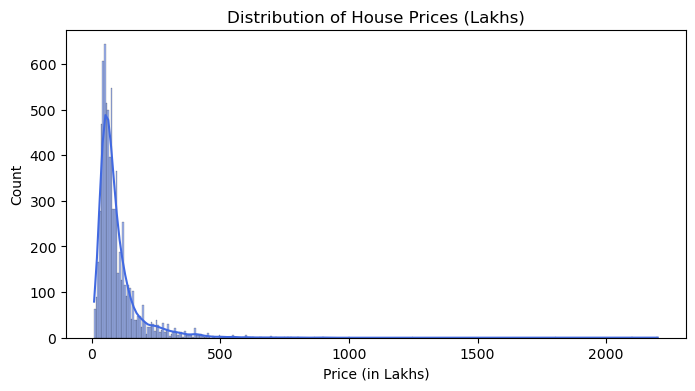

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(y, kde=True, color='royalblue')
plt.title('Distribution of House Prices (Lakhs)')
plt.xlabel('Price (in Lakhs)')
plt.show()


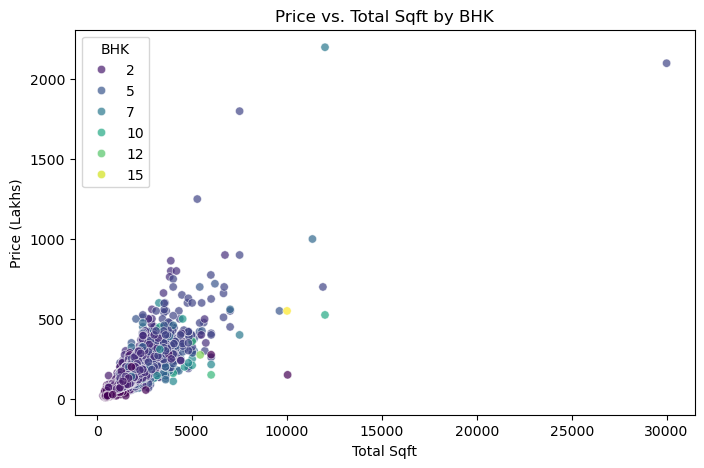

In [12]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['total_sqft'], y=df['price'], hue=df['bhk'], palette='viridis', alpha=0.7)
plt.title('Price vs. Total Sqft by BHK')
plt.xlabel('Total Sqft')
plt.ylabel('Price (Lakhs)')
plt.legend(title='BHK')
plt.show()


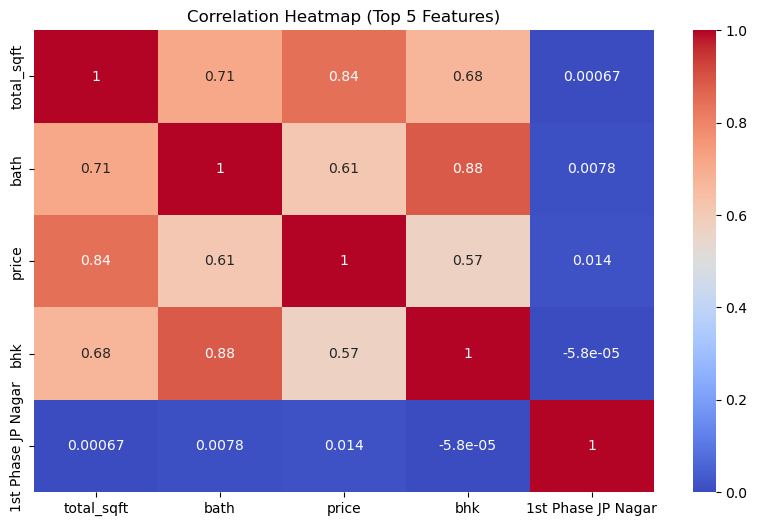

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_model.corr().iloc[:5, :5], annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Top 5 Features)')
plt.show()


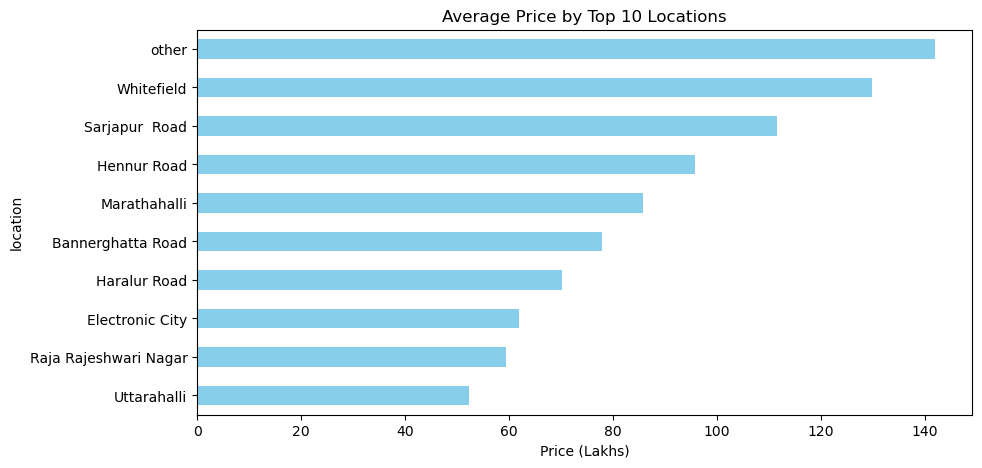

In [14]:
top_locations = df['location'].value_counts().head(10).index
loc_price = df[df['location'].isin(top_locations)].groupby('location')['price'].mean().sort_values()

plt.figure(figsize=(10, 5))
loc_price.plot(kind='barh', color='skyblue')
plt.title('Average Price by Top 10 Locations')
plt.xlabel('Price (Lakhs)')
plt.show()


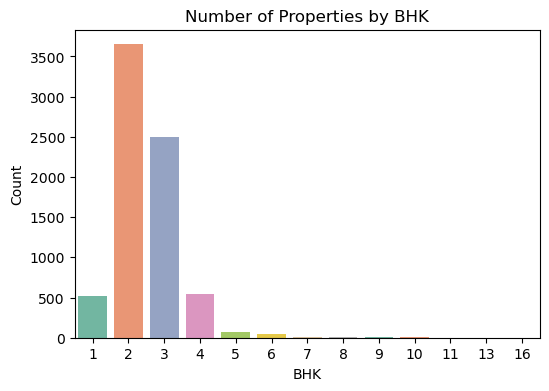

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x='bhk', data=df, hue='bhk', palette='Set2', legend=False)
plt.title('Number of Properties by BHK')
plt.xlabel('BHK')
plt.ylabel('Count')
plt.show()


In [17]:
# STEP 4.1: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 2. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 3. XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [19]:
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"\n📊 {name} Evaluation:")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: ₹{mae:.2f} Lakhs")
    print(f"RMSE: ₹{rmse:.2f} Lakhs")


In [20]:
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)



📊 Linear Regression Evaluation:
R2 Score: 0.8646
MAE: ₹19.24 Lakhs
RMSE: ₹40.02 Lakhs

📊 Random Forest Evaluation:
R2 Score: 0.8128
MAE: ₹17.03 Lakhs
RMSE: ₹47.05 Lakhs

📊 XGBoost Evaluation:
R2 Score: 0.7694
MAE: ₹19.15 Lakhs
RMSE: ₹52.22 Lakhs


In [28]:
#Cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(lr_model, X, y, scoring='r2', cv=5)
print("Cross-validated R² scores:", cv_scores)
print("Mean R²:", np.mean(cv_scores))


Cross-validated R² scores: [ 0.54846015 -2.53325222 -1.6983986  -2.56552998 -0.06796473]
Mean R²: -1.2633370754311013


In [29]:
model_columns = list(X.columns)
# Save Linear Regression model
joblib.dump(lr_model, "bengaluru_price_model.pkl")

# Save feature columns
joblib.dump(model_columns, "model_columns.pkl")

print("✅ Linear Regression model saved as 'bengaluru_price_model.pkl'")


✅ Linear Regression model saved as 'bengaluru_price_model.pkl'
